Shape of theta_rise: (1250,)
Shape of theta_dwell: (625,)
Shape of theta_fall: (1250,)
Shape of theta_dwell2: (1875,)


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1253: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


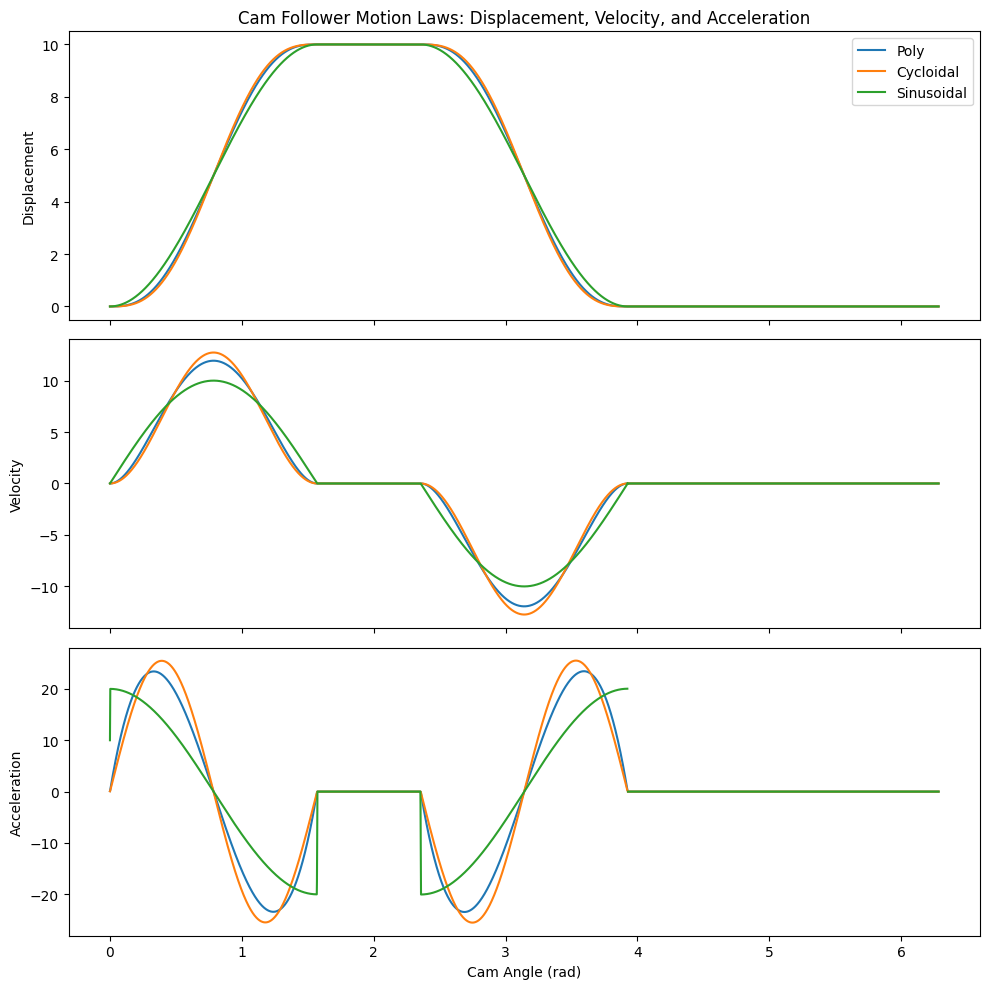

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# PARAMETERS
L = 10                              # Total lift
theta_total = 2 * np.pi            # Full cam rotation (0 to 2π)
N = 5000                           # High resolution for smoother derivatives

# Phase durations
theta_ri = np.pi / 2               # Rise over 90°
theta_dw = np.pi / 4               # Dwell for 45°
theta_fall = np.pi / 2             # Fall over 90°
theta_dw2 = theta_total - (theta_ri + theta_dw + theta_fall)

# Phase divisions (angle arrays)
num_rise = int(N * (theta_ri / theta_total))
num_dwell = int(N * (theta_dw / theta_total))
num_fall = int(N * (theta_fall / theta_total))
num_dwell2 = N - (num_rise + num_dwell + num_fall)

# Avoid overlaps using endpoint=False
theta_rise = np.linspace(0, theta_ri, num_rise, endpoint=False)
theta_dwell = np.linspace(theta_ri, theta_ri + theta_dw, num_dwell, endpoint=False)
theta_fall = np.linspace(theta_ri + theta_dw, theta_ri + theta_dw + theta_fall, num_fall, endpoint=False)

# Fix: Ensure the start point for theta_dwell2 is a scalar by taking the last element of theta_fall
start_theta_dwell2 = theta_fall[-1]

theta_dwell2 = np.linspace(start_theta_dwell2, theta_total, num_dwell2, endpoint=True)

# Debugging print statements for array shapes
print(f"Shape of theta_rise: {theta_rise.shape}")
print(f"Shape of theta_dwell: {theta_dwell.shape}")
print(f"Shape of theta_fall: {theta_fall.shape}")
print(f"Shape of theta_dwell2: {theta_dwell2.shape}")


# Normalize helper
def normalize(t, t0, tf):
    return (t - t0) / (tf - t0)

# Motion profiles
def poly_profile(t, t0, tf, L):
    x = normalize(t, t0, tf)
    return L * (10 * x**3 - 15 * x**4 + 6 * x**5)

def cycloidal_profile(t, t0, tf, L):
    x = normalize(t, t0, tf)
    return L * (x - (1/(2*np.pi)) * np.sin(2*np.pi * x))

def sinusoidal_profile(t, t0, tf, L):
    x = normalize(t, t0, tf)
    return (L / 2) * (1 - np.cos(np.pi * x))

# Derivatives using edge_order=1 to avoid kinks
def velocity(y, theta):
    return np.gradient(y, theta, edge_order=1)

def acceleration(y, theta):
    return np.gradient(np.gradient(y, theta, edge_order=1), theta, edge_order=1)

# Generate profiles
profiles = {}
for law in ['poly', 'cycloidal', 'sinusoidal']:
    if law == 'poly':
        y_rise = poly_profile(theta_rise, 0, theta_ri, L)
        y_fall = L - poly_profile(theta_fall, theta_fall[0], theta_fall[-1], L)
    elif law == 'cycloidal':
        y_rise = cycloidal_profile(theta_rise, 0, theta_ri, L)
        y_fall = L - cycloidal_profile(theta_fall, theta_fall[0], theta_fall[-1], L)
    elif law == 'sinusoidal':
        y_rise = sinusoidal_profile(theta_rise, 0, theta_ri, L)
        y_fall = L - sinusoidal_profile(theta_fall, theta_fall[0], theta_fall[-1], L)

    y_dwell = np.full_like(theta_dwell, L)
    y_dwell2 = np.zeros_like(theta_dwell2)

    theta_full = np.concatenate([theta_rise, theta_dwell, theta_fall, theta_dwell2])
    y_full = np.concatenate([y_rise, y_dwell, y_fall, y_dwell2])

    v_full = velocity(y_full, theta_full)
    a_full = acceleration(y_full, theta_full)

    profiles[law] = {
        'theta': theta_full,
        'displacement': y_full,
        'velocity': v_full,
        'acceleration': a_full
    }

# Plot results
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for law in profiles:
    theta = profiles[law]['theta']
    axs[0].plot(theta, profiles[law]['displacement'], label=law.title())
    axs[1].plot(theta, profiles[law]['velocity'], label=law.title())
    axs[2].plot(theta, profiles[law]['acceleration'], label=law.title())

axs[0].set_ylabel('Displacement')
axs[1].set_ylabel('Velocity')
axs[2].set_ylabel('Acceleration')
axs[2].set_xlabel('Cam Angle (rad)')
axs[0].set_title("Cam Follower Motion Laws: Displacement, Velocity, and Acceleration")
axs[0].legend()

plt.tight_layout()
plt.show()